# **1. Entendimento do negócio**


## **1.1 A empresa**

  A empresa JPA AGRO é uma plataforma que conecta empresas que produzem e clientes que consomem. A empresa está no mercado há mais de 10 anos e entre suas principais parcerias estão empresas de confinamentos, granjas, fábricas de ração, cooperativas, entre outros. Hoje passam pela JPA Agro mais de 140 milhões por ano e a expectativa é que esse valor chegue a 500 milhões nos próximos 10 anos.

  A polpa cítrica é o “carro-chefe” da empresa. É um produto derivado da laranja e utilizado como fonte de energia na dieta de ruminantes, principalmente como substituto do milho. A principal região produtora de polpa no país é o estado de São Paulo.

## **1.2 Objetivo**

Realizar previsão do preço do produto polpa cítrica dos póoximos 30 dias após julho de 2019, em uma base de dados que contempla registro de vendas no período de 2014 a julho de 2019.

## **1.3 Métrica de avaliação**

As soluções de predição de preços de venda apresentadas serão avaliadas em termos de RMSE (Root Mean Square Error) para cada um dos próximos 30 dias úteis, a partir da última data do conjunto de dados disponibilizado.





# **2 Importação de bibliotecas e funções**






In [1]:
!pip install boruta
!pip install xgboost
!pip install lightgbm
!pip install scikit-optimize

     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 102kB 6.5MB/s 


In [2]:
from google.colab                    import drive   
import pandas                        as pd
import numpy                         as np
import matplotlib.pyplot             as plt
import seaborn                       as sns
from boruta                          import BorutaPy
from scipy.stats                     import friedmanchisquare, shapiro
from sklearn.preprocessing           import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics                 import mean_squared_error,mean_absolute_error
from sklearn.ensemble                import RandomForestRegressor
from sklearn.neural_network          import MLPRegressor
from sklearn.linear_model            import LinearRegression
from sklearn.svm                     import SVR
import matplotlib.ticker             as mtick
from matplotlib.ticker               import FormatStrFormatter
from statsmodels.graphics.tsaplots   import plot_pacf
from statsmodels.graphics.tsaplots   import plot_acf
import os
import joblib                        as jb
from dateutil.relativedelta          import *
import pdb
from xgboost                         import XGBRegressor
from lightgbm                        import LGBMRegressor
from sklearn.model_selection         import RandomizedSearchCV
import skopt

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **2.1 Funções auxiliares**

In [3]:
def getStatistic(df):
  df_stats = pd.DataFrame()
  numericos = df.select_dtypes(include=['int32','int64','float64'])
  df_stats['MEDIA']     = df[numericos.columns].mean()
  df_stats['MEDIANA']   = df[numericos.columns].median()
  df_stats['DESVIO']    = numericos.std()
  df_stats['MIN']       = numericos.min()
  df_stats['MAX']       = numericos.max()
  df_stats['INTERVALO'] = numericos.apply(lambda x: x.max() - x.min())
  df_stats['SKEW']      = numericos.skew()
  df_stats['CURTOSE']   = numericos.kurtosis()
  df_stats['CV']        = numericos.std()/numericos.mean()*100

  return df_stats

In [4]:
def boxplots(df,ignore_columns=[],use_copy=True,
             separador_direita=3,largura_boxplot=1):
    if use_copy:
        data = df.copy()
    else:
        data = df
        
    data.drop(columns=ignore_columns,inplace=True)
    data_to_plot = data  
    fig, ax = plt.subplots(ncols=len(data_to_plot.columns))
    plt.subplots_adjust(right=separador_direita, wspace=largura_boxplot)
    for i, col in enumerate(data_to_plot.columns):
        sns.boxplot(y=data_to_plot[col], ax = ax[i]);   

In [5]:
def plot_predict(wdf,y_pred,y_true):
  dplot = wdf.copy()
  plt.clf()
  plt.figure(1)
  fig, ax = plt.subplots(figsize=(10,6))
  ax.plot(y_pred, label='Previsto')
  ax.plot(y_true, label='Real')
  ax.set_xlabel('Período')
  ax.set_ylabel('R$')
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))          
  ax.set_xticks(range(0,dplot.shape[0],2))
  ax.set_xticklabels(dplot['negotiation_date'].loc[::2].dt.strftime('%Y-%m-%d'),rotation=90)  
  ax.set_title('Previsão')
  ax.legend()


In [6]:
def mean_percentage_error(y_true,y_pred):
  return np.mean((y_true-y_pred)/ytrue)

def mean_absolute_percentage_error(y_true,y_pred):
  return np.mean( np.abs( (y_true-y_pred)/y_true ))

def error_metrics(model_name,y_true,y_pred):
  mae = mean_absolute_error(y_true,y_pred)
  rmse = mean_squared_error(y_true,y_pred,squared=False)
  mape = mean_absolute_percentage_error(y_true,y_pred)
 
  
  return pd.DataFrame({'model_name': model_name,                       
                       'MAE' :  mae,
                       'MAPE': mape,
                       'RMSE': rmse
                      }, index=[0])

# **3 CARREGAMENTO E DESCRIÇÃO DOS DADOS**

In [7]:
drive.mount('/gdrive')
path = '/gdrive/My Drive/DataSets/hackathon/'
os.chdir(path)

Mounted at /gdrive


In [8]:
os.getcwd()

'/gdrive/My Drive/DataSets/hackathon'

In [9]:
df = pd.read_csv('https://github.com/dsrg-icet/hackathon_JPAAgro/blob/main/dataset/dataset_train.csv?raw=True',parse_dates=['negotiation_date'],dayfirst=True)

In [10]:
df.head()

,negotiation_date,sold_price,product
0,2014-01-07,308.33,Polpa Cítrica
1,2014-01-08,300.67,Polpa Cítrica
2,2014-01-09,295.00,Polpa Cítrica
3,2014-01-10,324.00,Polpa Cítrica
4,2014-01-11,250.71,Polpa Cítrica


In [11]:
df[df.duplicated()]

,negotiation_date,sold_price,product


# **3.1 Dicionário dos dados**



*   **product**: produto comercializado (valor constante igual 'Polpa Cítrica'.
*   **negotiation_date**: data do faturamento do produto
*   **sold_price**: preço de venda do produto (variável a ser predita)



## **3.2 Dimensão dos dados**

In [12]:
df.shape

(1637, 3)

## **3.3 Tipo de dados**

In [13]:
df.dtypes

negotiation_date    datetime64[ns]
sold_price                 float64
product                     object
dtype: object

In [14]:
df.head()

,negotiation_date,sold_price,product
0,2014-01-07,308.33,Polpa Cítrica
1,2014-01-08,300.67,Polpa Cítrica
2,2014-01-09,295.00,Polpa Cítrica
3,2014-01-10,324.00,Polpa Cítrica
4,2014-01-11,250.71,Polpa Cítrica


Colocando a data no formato datetime

In [15]:
df['negotiation_date'] = pd.to_datetime(df['negotiation_date'])

In [16]:
np.unique(df['product'],return_counts=True)

(array(['Polpa Cítrica'], dtype=object), array([1637]))

Como só temos um produto, a coluna product é desnecessária

In [17]:
df.drop('product',axis=1,inplace=True)

## **3.3 Verificando dados faltantes**

In [18]:
df.isnull().sum()

negotiation_date    0
sold_price          0
dtype: int64

## **3.4 Estatística descritiva**

In [19]:
df2 = getStatistic(df)

In [20]:
df2

,MEDIA,MEDIANA,DESVIO,MIN,MAX,INTERVALO,SKEW,CURTOSE,CV
sold_price,379.735278,343.6,130.371704,145.0,845.0,700.0,0.740081,0.042978,34.33226


O único atributo numérico que temos é o sold_price, no qual possui uma distribuição assimétrica positiva, tendo como seu menor preço 145 e máximo de 845. Sua média e mediana são bem próximas e se aproximam de uma distribuição normal. De acordo com a curtose, a distribuição terá uma curva da função com um pico mais alto do que uma distribuição normal (Leptocúrtica).

In [21]:
df.head(20)

,negotiation_date,sold_price
0,2014-01-07,308.33
1,2014-01-08,300.67
2,2014-01-09,295.00
3,2014-01-10,324.00
4,2014-01-11,250.71
5,2014-01-12,250.00
6,2014-01-15,305.00
7,2014-01-21,335.00
8,2014-01-22,338.50
9,2014-01-23,336.75


A série temporal é irregular como podemos ver, será necessário corrigir a série para se tornar regular como uma sequência diária.

## **3.5 Corrigindo falha temporal**

In [22]:
df2 = df.copy()

In [23]:
start = df2['negotiation_date'].head(1).values[0]
end= df2['negotiation_date'].tail(1).values[0]

In [24]:
start

numpy.datetime64('2014-01-07T00:00:00.000000000')

In [25]:
end

numpy.datetime64('2019-07-31T00:00:00.000000000')

In [26]:
df_aux = pd.date_range(start=start,end=end,name='negotiation_date').to_frame().reset_index(drop=True)

In [27]:
full = pd.merge(left=df_aux,right=df2,how='left',left_on='negotiation_date',right_on='negotiation_date')

In [28]:
full.isnull().sum()

negotiation_date      0
sold_price          395
dtype: int64

Existem 395 dias com falha temporal entre 07/01/2014 á 31/07/2019. Irei considerar o mesmo preço do dia anterior para os preços com NaN valores.

In [29]:
full.head(10)

,negotiation_date,sold_price
0,2014-01-07,308.33
1,2014-01-08,300.67
2,2014-01-09,295.00
3,2014-01-10,324.00
4,2014-01-11,250.71
5,2014-01-12,250.00
6,2014-01-13,NaN
7,2014-01-14,NaN
8,2014-01-15,305.00
9,2014-01-16,NaN


In [30]:
full['sold_price'].fillna(method='ffill',inplace=True)

In [31]:
full.tail()

,negotiation_date,sold_price
2027,2019-07-27,320.0
2028,2019-07-28,320.0
2029,2019-07-29,305.0
2030,2019-07-30,350.0
2031,2019-07-31,315.0


# **4.0 Feature Engineering**

In [82]:
df3=full.copy()

In [83]:
# year
df3['year'] = df3['negotiation_date'].dt.year

# month
df3['month'] = df3['negotiation_date'].dt.month

# day
df3['day'] = df3['negotiation_date'].dt.day

# week of year
df3['week_of_year'] = df3['negotiation_date'].dt.isocalendar().week

# year week
df3['year_week'] = df3['negotiation_date'].dt.strftime('%Y-%W')

#day week
df3['day_week'] = df3['negotiation_date'].dt.weekday

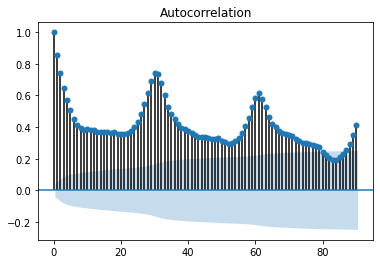

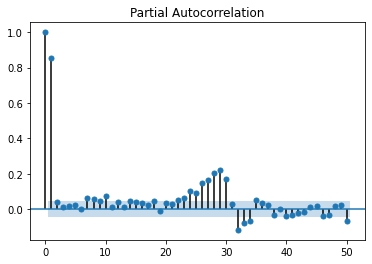

In [84]:
plot_acf(df3.sold_price,lags=90);
plot_pacf(df3.sold_price,lags=50);

* o gráfico da função (ACF) nos ajuda a identificar se a série é estacionária, caso fosse o gráfico mostraria um decaimento para 0 relativamente rápido, no entanto pelo gráfico o decaimento é lento. Já o gráfico de correlaçaõ parcial (PACF) nos mostra que o lag 1 possui forte correlação com nosso alvo **sold_price**.

* Abaixo irei gerar diferentes lags (sold_price_lag) e também fazer a diferenciação da série com valores anteriores (sold_price_diff).

In [85]:
for i in range(1,6):
  df3['sold_price_lag_{}'.format(i)] = df3['sold_price'].shift(i)

In [86]:
for i in range(1,6):
  df3['sold_price_diff_{}'.format(i)] = df3['sold_price'].diff(i)  

In [87]:
df3.tail()

,negotiation_date,sold_price,year,month,day,week_of_year,year_week,day_week,sold_price_lag_1,sold_price_lag_2,sold_price_lag_3,sold_price_lag_4,sold_price_lag_5,sold_price_diff_1,sold_price_diff_2,sold_price_diff_3,sold_price_diff_4,sold_price_diff_5
2027,2019-07-27,320.0,2019,7,27,30,2019-29,5,324.09,321.67,316.67,328.57,306.67,-4.09,-1.67,3.33,-8.57,13.33
2028,2019-07-28,320.0,2019,7,28,30,2019-29,6,320.00,324.09,321.67,316.67,328.57,0.00,-4.09,-1.67,3.33,-8.57
2029,2019-07-29,305.0,2019,7,29,31,2019-30,0,320.00,320.00,324.09,321.67,316.67,-15.00,-15.00,-19.09,-16.67,-11.67
2030,2019-07-30,350.0,2019,7,30,31,2019-30,1,305.00,320.00,320.00,324.09,321.67,45.00,30.00,30.00,25.91,28.33
2031,2019-07-31,315.0,2019,7,31,31,2019-30,2,350.00,305.00,320.00,320.00,324.09,-35.00,10.00,-5.00,-5.00,-9.09


In [88]:
df3.dropna(inplace=True)

# **5.0 Análise exploratória**

In [89]:
df4 = df3.copy()

## **5.1 Análise da variável de saída**

In [90]:
df4.describe()

,sold_price,year,month,day,week_of_year,day_week,sold_price_lag_1,sold_price_lag_2,sold_price_lag_3,sold_price_lag_4,sold_price_lag_5,sold_price_diff_1,sold_price_diff_2,sold_price_diff_3,sold_price_diff_4,sold_price_diff_5
count,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000
mean,388.541944,2016.324618,6.291564,15.773557,25.619142,2.998520,388.510227,388.497400,388.492467,388.482930,388.477173,0.031717,0.044544,0.049477,0.059013,0.064771
std,132.016087,1.617464,3.402331,8.789663,14.842842,2.001356,132.041485,132.046491,132.049798,132.055445,132.058687,70.744700,94.584316,110.702783,122.372282,131.125159
min,145.000000,2014.000000,1.000000,1.000000,1.000000,0.000000,145.000000,145.000000,145.000000,145.000000,145.000000,-395.220000,-470.830000,-530.000000,-568.500000,-700.000000
25%,280.000000,2015.000000,3.000000,8.000000,13.000000,1.000000,280.000000,280.000000,280.000000,280.000000,280.000000,-11.500000,-19.835000,-23.330000,-28.465000,-31.995000
50%,360.000000,2016.000000,6.000000,16.000000,25.000000,3.000000,360.000000,360.000000,360.000000,360.000000,360.000000,0.000000,0.000000,0.000000,0.000000,0.920000
75%,470.000000,2018.000000,9.000000,23.000000,38.000000,5.000000,470.000000,470.000000,470.000000,470.000000,470.000000,13.945000,22.845000,29.915000,32.890000,35.885000
max,845.000000,2019.000000,12.000000,31.000000,53.000000,6.000000,845.000000,845.000000,845.000000,845.000000,845.000000,542.650000,646.690000,663.500000,638.230000,644.380000


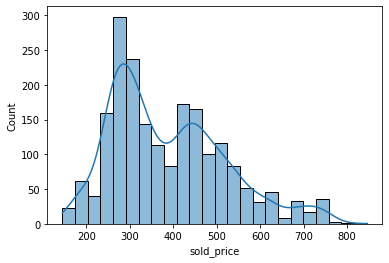

In [91]:
sns.histplot(df4.sold_price,kde=True)

como podemos ver a variável alvo não segue uma distribuição normal, como visto anteriormente sua média difere da mediana. Existem técnicas para transformá-la em uma normal, que será aplicado mais a frente.

## **5.2 Tendência do preço**

In [92]:
anual_tend = df4['sold_price'].rolling(window=365,center=True).mean().to_frame()
mm7        = df4['sold_price'].rolling(window=7,center=True).mean().to_frame()

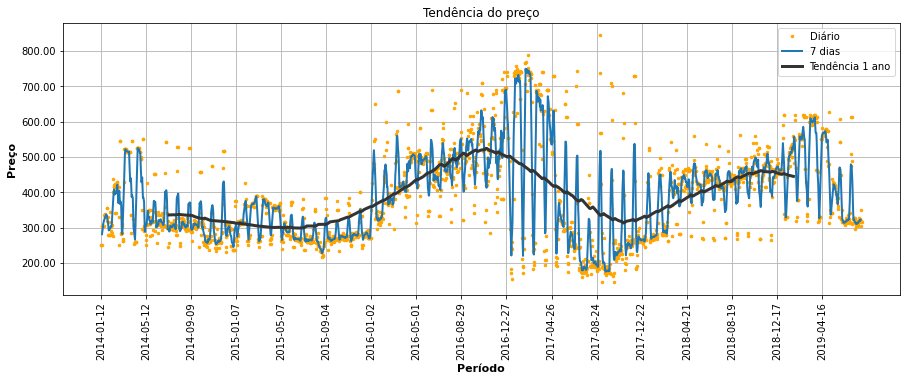

In [93]:
fig, ax = plt.subplots(figsize = (15,5))

PERIODO_GRAPHIC = 120
ax.plot(df4['negotiation_date'].dt.strftime('%Y-%m-%d'),df4['sold_price'], marker='.', markersize=5, color='orange',linestyle='None', label='Diário')
ax.plot(df4['negotiation_date'].dt.strftime('%Y-%m-%d'),mm7['sold_price'], linewidth=2, label='7 dias')
ax.plot(df4['negotiation_date'].dt.strftime('%Y-%m-%d'),anual_tend['sold_price'], color='0.2', linewidth=3, label='Tendência 1 ano')
plt.xticks(range(0,df4.shape[0],PERIODO_GRAPHIC),df4['negotiation_date'].dt.date.loc[::PERIODO_GRAPHIC],rotation=90)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f')) 
ax.legend()
ax.set_xlabel('Período',fontweight='bold',fontsize=11)
ax.set_ylabel('Preço',fontweight='bold',fontsize=11)
plt.grid(True)
plt.title('Tendência do preço')
plt.show()

## **6 Transformação dos dados**

In [170]:
df5 = df4.copy()

In [171]:
treino = df5[df5['negotiation_date']<'2019-07-01'].copy()
teste  = df5[df5['negotiation_date']>='2019-07-01'].copy()

In [172]:
df5.dtypes

negotiation_date     datetime64[ns]
sold_price                  float64
year                          int64
month                         int64
day                           int64
week_of_year                 UInt32
year_week                    object
day_week                      int64
sold_price_lag_1            float64
sold_price_lag_2            float64
sold_price_lag_3            float64
sold_price_lag_4            float64
sold_price_lag_5            float64
sold_price_diff_1           float64
sold_price_diff_2           float64
sold_price_diff_3           float64
sold_price_diff_4           float64
sold_price_diff_5           float64
dtype: object

In [173]:
numerics = df5[['sold_price','sold_price_lag_1','year','sold_price_lag_2','sold_price_diff_1','sold_price_diff_2']]

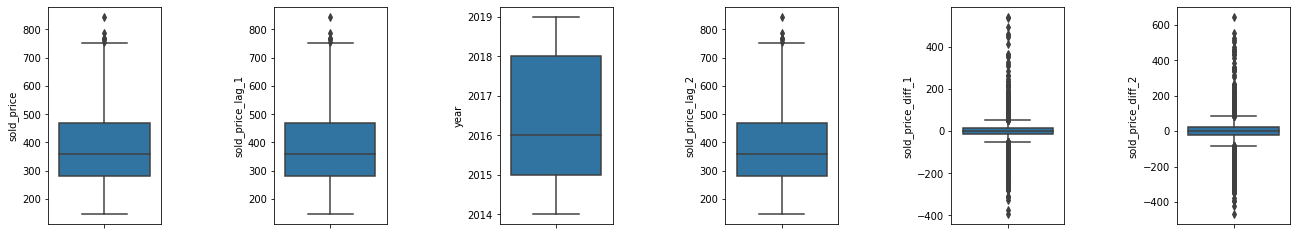

In [174]:
boxplots(numerics)

* Conforme boxplots acima, os atributos sold_price_lag_1, sold_price_lag_2 possuem outliers, entretanto eles estão bem próximos do whisker superior, já os demais como sold_price_diff_1 ... sold_price_diff_5 possuem muitos outliers.

In [175]:
mms = MinMaxScaler()
rs = RobustScaler()

Transformando a nossa variável de saída em uma transformação normal através da função logarítimica

In [176]:
treino['sold_price'] = np.log1p(treino['sold_price'])

In [177]:
for i in range(1,6):
  treino['sold_price_lag_{}'.format(i)] = mms.fit_transform(treino[['sold_price_lag_{}'.format(i)]])
  jb.dump(mms,open('./scaler_price_lag_{}'.format(i)+'.pkl','wb'))

In [178]:
for i in range(1,6):
  treino['sold_price_diff_{}'.format(i)] = rs.fit_transform(treino[['sold_price_diff_{}'.format(i)]])
  jb.dump(rs,open('./scaler_price_diff_{}'.format(i)+'.pkl','wb'))  

In [179]:
treino['year'] =  mms.fit_transform(treino[['year']])
jb.dump(mms,open('./scaler_year.pkl','wb'))

In [180]:
treino['month_sin'] = treino['month'].apply(lambda x: np.sin(x * (2* np.pi/12)))
treino['month_cos'] = treino['month'].apply(lambda x: np.cos(x * (2* np.pi/12)))

treino['week_of_year_sin'] =treino['week_of_year'].apply(lambda x: np.sin(x * (2*np.pi/52)))
treino['week_of_year_cos'] =treino['week_of_year'].apply(lambda x: np.cos(x * (2*np.pi/52)))

treino['day_sin'] = treino['day'].apply(lambda x: np.sin(x * (2*np.pi/30)))
treino['day_cos'] = treino['day'].apply(lambda x: np.cos(x * (2*np.pi/30)))

treino['day_week_sin'] = treino['day_week'].apply(lambda x: np.sin(x * (2*np.pi/7)))
treino['day_week_cos'] = treino['day_week'].apply(lambda x: np.cos(x * (2*np.pi/7)))

teste['month_sin'] = teste['month'].apply(lambda x: np.sin(x * (2* np.pi/12)))
teste['month_cos'] = teste['month'].apply(lambda x: np.cos(x * (2* np.pi/12)))

teste['week_of_year_sin'] =teste['week_of_year'].apply(lambda x: np.sin(x * (2*np.pi/52)))
teste['week_of_year_cos'] =teste['week_of_year'].apply(lambda x: np.cos(x * (2*np.pi/52)))

teste['day_sin'] = teste['day'].apply(lambda x: np.sin(x * (2*np.pi/30)))
teste['day_cos'] = teste['day'].apply(lambda x: np.cos(x * (2*np.pi/30)))

teste['day_week_sin'] = teste['day_week'].apply(lambda x: np.sin(x * (2*np.pi/7)))
teste['day_week_cos'] = teste['day_week'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# **7 Seleção de Features**

In [181]:
df6 = treino.copy()

In [182]:
df6.drop(['week_of_year','day','month','year_week','day_week'],axis=1,inplace=True)
teste.drop(['week_of_year','day','month','year_week','day_week'],axis=1,inplace=True)

In [183]:
df6.head()

,negotiation_date,sold_price,year,sold_price_lag_1,sold_price_lag_2,sold_price_lag_3,sold_price_lag_4,sold_price_lag_5,sold_price_diff_1,sold_price_diff_2,sold_price_diff_3,sold_price_diff_4,sold_price_diff_5,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos,day_week_sin,day_week_cos
5,2014-01-12,5.525453,0.0,0.151014,0.255714,0.214286,0.222386,0.233329,-0.027549,-1.716141,-0.838340,-0.819141,-0.863678,0.5,0.866025,0.239316,0.970942,5.877853e-01,-0.809017,-0.781831,0.623490
6,2014-01-13,5.525453,0.0,0.150000,0.151014,0.255714,0.214286,0.222386,0.000000,-0.016466,-1.378604,-0.727478,-0.752085,0.5,0.866025,0.354605,0.935016,4.067366e-01,-0.913545,0.000000,1.000000
7,2014-01-14,5.525453,0.0,0.150000,0.150000,0.151014,0.255714,0.214286,0.000000,0.000000,-0.013227,-1.196298,-0.669483,0.5,0.866025,0.354605,0.935016,2.079117e-01,-0.978148,0.781831,0.623490
8,2014-01-15,5.723585,0.0,0.150000,0.150000,0.150000,0.151014,0.255714,2.134058,1.275510,1.024638,0.877662,-0.290709,0.5,0.866025,0.354605,0.935016,1.224647e-16,-1.000000,0.974928,-0.222521
9,2014-01-16,5.723585,0.0,0.228571,0.150000,0.150000,0.150000,0.151014,0.000000,1.275510,1.024638,0.889140,0.776997,0.5,0.866025,0.354605,0.935016,-2.079117e-01,-0.978148,0.433884,-0.900969


In [184]:
X_train_n = df6.drop(['sold_price','negotiation_date'],axis=1).values
y_train_n = df6['sold_price'].values
x=df6.drop(['sold_price','negotiation_date'],axis=1)
y=df6['sold_price']
rf = RandomForestRegressor(n_estimators=300)

boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=41)
boruta.fit(X_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	8
Iteration:

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=None,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=42, n_jobs=None,
                                         oob_score=False,
                                         random_state=RandomState(MT19937) at 0x7F924FEB5C00,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random

In [185]:
cols_select_boruta = boruta.support_.tolist()
print('Colunas selecionadas pelo boruta')
check_columns = df6.drop(['sold_price','negotiation_date'],axis=1)
cols_select_boruta
colunas_selecionadas = check_columns.columns[cols_select_boruta]
colunas_selecionadas
colunas_selecionadas=colunas_selecionadas.tolist()
colunas_selecionadas.extend(['negotiation_date','sold_price'])

Colunas selecionadas pelo boruta


In [186]:
colunas_selecionadas

['sold_price_lag_1',
 'sold_price_lag_2',
 'sold_price_diff_1',
 'sold_price_diff_2',
 'sold_price_diff_3',
 'sold_price_diff_4',
 'sold_price_diff_5',
 'day_sin',
 'negotiation_date',
 'sold_price']

In [187]:
df6 = df6[colunas_selecionadas]
treino = treino[colunas_selecionadas]
teste = teste[colunas_selecionadas]

# **8 Modelos de Machine Learning**

## **8.1 Separando os dados de treino e teste**

In [188]:
treino.tail()

,sold_price_lag_1,sold_price_lag_2,sold_price_diff_1,sold_price_diff_2,sold_price_diff_3,sold_price_diff_4,sold_price_diff_5,day_sin,negotiation_date,sold_price
1996,0.273814,0.242857,-0.864875,-0.014378,-0.197848,-0.056258,-0.144298,-7.431448e-01,2019-06-26,5.753778
1997,0.241971,0.273814,0.097003,-0.458952,0.035024,-0.131269,-0.028190,-5.877853e-01,2019-06-27,5.761674
1998,0.245543,0.241971,0.315065,0.246289,-0.217410,0.161662,-0.013913,-4.067366e-01,2019-06-28,5.786897
1999,0.257143,0.245543,0.582016,0.536178,0.477295,0.053833,0.350293,-2.079117e-01,2019-06-29,5.831882
2000,0.278571,0.257143,-0.905228,-0.193182,-0.003912,0.037021,-0.305277,-2.449294e-16,2019-06-30,5.761013


In [189]:
x_train = treino.drop(['sold_price','negotiation_date'],axis=1)
y_train = treino['sold_price'].values

In [190]:
teste['sold_price'] = np.log1p(teste['sold_price'])
teste['sold_price_lag_1'] = jb.load('./scaler_price_lag_1.pkl').transform(teste[['sold_price_lag_1']])
teste['sold_price_lag_2'] = jb.load('./scaler_price_lag_2.pkl').transform(teste[['sold_price_lag_2']])
teste['sold_price_diff_1'] = jb.load('./scaler_price_diff_1.pkl').transform(teste[['sold_price_diff_1']])
teste['sold_price_diff_2'] = jb.load('./scaler_price_diff_2.pkl').transform(teste[['sold_price_diff_2']])
teste['sold_price_diff_3'] = jb.load('./scaler_price_diff_3.pkl').transform(teste[['sold_price_diff_3']])
teste['sold_price_diff_4'] = jb.load('./scaler_price_diff_4.pkl').transform(teste[['sold_price_diff_4']])
teste['sold_price_diff_5'] = jb.load('./scaler_price_diff_5.pkl').transform(teste[['sold_price_diff_5']])

In [191]:
x_test = teste.drop(['sold_price','negotiation_date'],axis=1)
y_test = teste['sold_price'].values

In [192]:
y_test = np.expm1(y_test)

In [193]:
#y_test = scaler_price.inverse_transform(y_test.reshape(-1,1))

## **8.2 Baseline**

In [194]:
rf1 = RandomForestRegressor(n_estimators=700)
rf1.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [195]:
y_predrf = rf1.predict(x_test)
y_predrf = np.round(np.expm1(y_predrf),2)
print('RMSE: ',mean_squared_error(y_test,y_predrf,squared=False))

RMSE:  5.381355807097389


<Figure size 432x288 with 0 Axes>

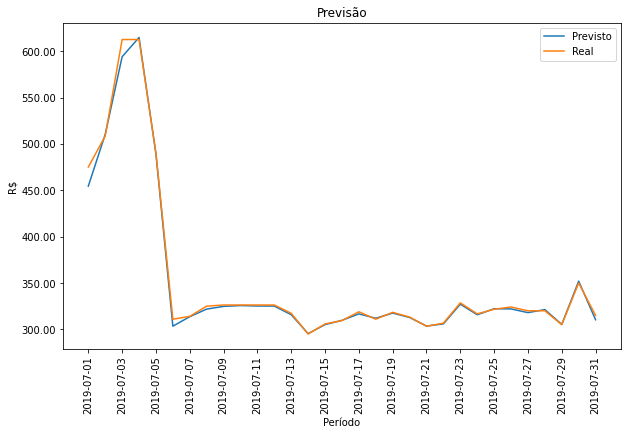

In [196]:
plot_predict(teste,y_predrf,y_test)

## **8.3 Aplicando em uma diversidade de modelos**

In [197]:
y_train_origin = np.expm1(y_train)

In [198]:
df_res = pd.DataFrame()
models = [('RandomForest',RandomForestRegressor(n_estimators=700)),
          ('MLP',MLPRegressor(max_iter=1000)),
          ('XGBoost',XGBRegressor(n_estimators=700)),
          ('LightGBM',LGBMRegressor(n_estimators=700)),
          ('LinearRegression',LinearRegression())]

for indice,mdl in enumerate(models):
  print(mdl[0])
  mdl[1].fit(x_train,y_train.ravel())
  y_pred = mdl[1].predict(x_test)
  y_pred = np.expm1(y_pred)

  y_pred_train = mdl[1].predict(x_train)
  y_pred_train = np.expm1(y_pred_train)
  
  df_res = df_res.append(error_metrics(mdl[0],y_test,y_pred),ignore_index=True)
  df_res = df_res.append(error_metrics(mdl[0]+'_train',y_train_origin,y_pred_train),ignore_index=True)

df_res


RandomForest
MLP
XGBoost
[12:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LightGBM
LinearRegression


,model_name,MAE,MAPE,RMSE
0,RandomForest,2.565724,0.006292,5.130109
1,RandomForest_train,1.773736,0.004442,4.739149
2,MLP,24.810847,0.060547,39.771407
3,MLP_train,30.476015,0.074097,48.756631
4,XGBoost,3.255027,0.008542,4.608139
5,XGBoost_train,1.570887,0.004063,2.158890
6,LightGBM,3.205120,0.008615,4.370752
7,LightGBM_train,0.645856,0.001684,1.469435
8,LinearRegression,12.249294,0.033500,14.371672
9,LinearRegression_train,19.263394,0.047646,31.394021


In [243]:
mdx = LGBMRegressor(n_estimators=700)
mdx.fit(x_train,y_train)
yp=mdx.predict(x_test)
yp = np.expm1(yp)

mdg = XGBRegressor(n_estimators=700,objective ='reg:squarederror')
mdg.fit(x_train,y_train)
yg=mdg.predict(x_test)
yg = np.expm1(yg)

In [200]:
mdx

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=700, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [201]:
mdg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=700,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [202]:
stacking = mean_squared_error(yp*0.6+yg*0.4,y_test,squared=False)

In [203]:
stacking

3.9179098778089743

In [277]:
def walk_forward_validation(treino,test,modelo):
    
    x_train = treino.drop(['negotiation_date','sold_price'],axis=1)
    y_train = treino.sold_price.values
    
    rmse_final=[]
    
    for index,row in test.iterrows():
        modelo.fit(x_train,y_train)
                
        row_test = row.drop(['negotiation_date','sold_price']).values.reshape(1,-1)
    
        y_pred_m1 = np.expm1(modelo.predict(row_test))      
       
        y_pred_final = mean_squared_error(np.asarray(row['sold_price']).ravel(),y_pred_m1,squared=False)

        print('Data: {} - Real: {} - Predito: {}'.format(row['negotiation_date'].strftime('%Y-%m-%d'),np.round(np.expm1(row['sold_price']),2),np.round(y_pred_final,2)))
        rmse_final.append(mean_squared_error(np.expm1(np.asarray(row['sold_price']).ravel()),y_pred_m1.ravel(),squared=False))
        treino = treino.append(row, ignore_index=True)
    return rmse_final, modelo, treino


In [278]:
rmse,modelo1,train = walk_forward_validation(treino,teste,mdx)

Data: 2019-07-01 - Real: 475.0 - Predito: 461.3
Data: 2019-07-02 - Real: 508.5 - Predito: 494.29
Data: 2019-07-03 - Real: 612.5 - Predito: 601.64
Data: 2019-07-04 - Real: 612.5 - Predito: 597.99
Data: 2019-07-05 - Real: 490.0 - Predito: 476.25
Data: 2019-07-06 - Real: 310.94 - Predito: 293.97
Data: 2019-07-07 - Real: 314.0 - Predito: 312.75
Data: 2019-07-08 - Real: 325.0 - Predito: 310.48
Data: 2019-07-09 - Real: 326.25 - Predito: 319.45
Data: 2019-07-10 - Real: 326.25 - Predito: 318.6
Data: 2019-07-11 - Real: 326.25 - Predito: 318.35
Data: 2019-07-12 - Real: 326.25 - Predito: 318.77
Data: 2019-07-13 - Real: 317.31 - Predito: 309.21
Data: 2019-07-14 - Real: 295.0 - Predito: 289.96
Data: 2019-07-15 - Real: 305.83 - Predito: 299.46
Data: 2019-07-16 - Real: 309.44 - Predito: 303.88
Data: 2019-07-17 - Real: 318.95 - Predito: 309.71
Data: 2019-07-18 - Real: 310.94 - Predito: 303.19
Data: 2019-07-19 - Real: 318.33 - Predito: 309.84
Data: 2019-07-20 - Real: 313.24 - Predito: 306.88
Data: 2019

In [284]:
print('RMSE: ',np.asarray(rmse).mean())

RMSE:  3.205119505441037


# **8.3 Tunado Hyperparâmetros**

In [285]:
gridParams = {
    'learning_rate': [0.1,0.001,0.2],
    'n_estimators': [100,600,700],
    'num_leaves': [31,32,35],
    'subsample' : [1.0,0.6,0.75],
    'reg_alpha' : [0.0,1.0],
    'reg_lambda' : [0.0,0.1],
    'min_child_samples' : [20,22,23,10],
    }

In [286]:
lgb_tunning = LGBMRegressor(n_jobs=-1)

In [287]:
rnd_grid =  skopt.BayesSearchCV(estimator=lgb_tunning,search_spaces=gridParams,n_jobs=-1,verbose=1)

In [288]:
rnd_grid.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


BayesSearchCV(cv=None, error_score='raise',
              estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, sil...
              fit_params=None, iid=True, n_iter=50, n_jobs=-1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False, scoring=None,
              search_spaces={'learning_rate': [0.1

In [289]:
print(rnd_grid.best_params_)
print(rnd_grid.best_score_)

OrderedDict([('learning_rate', 0.1), ('min_child_samples', 10), ('n_estimators', 600), ('num_leaves', 32), ('reg_alpha', 0.0), ('reg_lambda', 0.07934050231726474), ('subsample', 0.75)])
0.9793237423244302
